## Input Analysis

In [1]:
import numpy as np
import scipy.stats as st
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt


data = pd.read_csv('TonerItDown.csv')
data = data[data['Time of day']<24]
n = len(data)

#Create rate table for Request generation
emp_rate = data.groupby(data['Time of day'].apply(np.floor)).size() / 60
emp_rate = emp_rate.values
coeffs = np.polyfit(np.arange(3,22),emp_rate[3:22],deg = 2)
fitted_rate = np.zeros(24)
fitted_rate[3:22] = coeffs[0]*np.arange(3,22) ** 2 + coeffs[1]*np.arange(3,22) + coeffs[2]
fitted_rate[[0,1,2,22,23]] = np.mean(emp_rate[[0,1,2,22,23]])
rates = pd.DataFrame(data = fitted_rate,columns = ['fitted rate'])


#Paramaters for Initial Diagnosis Time fitted to the normal distribution 
param_diagnose_a = st.norm.fit(data[data['Request location'].isin
                         (['BC_1','BC_10','BC_4','BC_5','BC_6','BC_7','BC_8'])]['Initial diagnose time'])
param_diagnose_b = st.norm.fit(data[data['Request location'].isin(['BC_2','BC_3','BC_9'])]
                               ['Initial diagnose time'])


# Paramaters for the beta distribution fit for Onsite Repair Time
data_on_site = data['On-site repair time'][data['Needs Replacement?'] != 'yes']
n_on_site = len(data_on_site)
params_repair_beta = st.beta.fit(data_on_site)


#Empirical Probabilities of a call orginating at a BC
p_hat = data.groupby(by = 'Request location')['Initial diagnose time'].size() / n
std = np.sqrt(p_hat * (1-p_hat))
probabilities = p_hat.values.tolist()


# Create Python objects from data given in problem specification
Distances = {
            "BC1":{"BC1": 0,"BC2": 20,"BC3": 30,"BC4": 45,"BC5": 50,"BC6": 50,"BC7": 60,"BC8": 55,"BC9": 60,"BC10": 70,"Dispatch":45},
            "BC2":{"BC2": 0,"BC1": 20,"BC3": 10,"BC4": 25,"BC5": 30,"BC6": 50,"BC7": 60,"BC8": 55,"BC9": 60,"BC10": 70,"Dispatch": 45},
            "BC3":{"BC3": 0,"BC1": 30,"BC2": 10,"BC4": 15,"BC5": 20,"BC6": 40,"BC7": 50,"BC8": 45,"BC9": 50,"BC10": 60,"Dispatch": 35},
            "BC4":{"BC4": 0,"BC1": 45,"BC2": 25,"BC3": 15,"BC5": 5 ,"BC6": 55,"BC7": 65,"BC8": 60,"BC9": 65,"BC10": 75,"Dispatch": 50},
            "BC5":{"BC5": 0,"BC1": 50,"BC2": 30,"BC3": 20,"BC4": 5 ,"BC6": 60,"BC7": 70,"BC8": 65,"BC9": 70,"BC10": 80,"Dispatch": 55},
            "BC6":{"BC6": 0,"BC1": 50,"BC2": 50,"BC3": 40,"BC4": 55,"BC5": 60,"BC7": 10,"BC8": 5 ,"BC9": 10,"BC10": 20,"Dispatch": 25},
            "BC7":{"BC7": 0,"BC1": 60,"BC2": 60,"BC3": 50,"BC4": 65,"BC5": 70,"BC6": 10,"BC8": 15,"BC9": 20,"BC10": 10,"Dispatch": 35},
            "BC8":{"BC8": 0,"BC1": 55,"BC2": 55,"BC3": 45,"BC4": 60,"BC5": 65,"BC6": 5 ,"BC7": 15,"BC9": 5 ,"BC10": 15,"Dispatch": 30},
            "BC9":{"BC9": 0,"BC1": 60,"BC2": 60,"BC3": 50,"BC4": 65,"BC5": 70,"BC6": 10,"BC7": 20,"BC8": 5 ,"BC10": 10,"Dispatch": 35},
            "BC10":{"BC10": 0,"BC1":70,"BC2": 70,"BC3": 60,"BC4": 75,"BC5": 80,"BC6": 20,"BC7": 10,"BC8": 15,"BC9" : 10,"Dispatch": 45}}

BusinessCenters = ["BC1", "BC2", "BC3", "BC4", "BC5", "BC6", "BC7", "BC8", "BC9", "BC10"]

/home/jackson/.local/lib/python3.6/site-packages/scipy/stats/_continuous_distns.py:515: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)


In [11]:
class Request:
    def __init__(self, initialized_time):
        """Initialize Random location and Random interarival time for Request"""
        self.loc = np.random.choice(BusinessCenters,1,p=probabilities)[0]
        self.status = "Waiting"
        self.initialized_time = initialized_time + dt.timedelta(minutes=
                int(np.random.poisson((rates[rates.index == initialized_time.hour]['fitted rate'] * 60), 1)[0]))
        self.times = [self.initialized_time]
        self.assigned_mechanic = None
        self.assigned_van = None
        
    def add_travel_time_mech(self, now) :
        """Time to travel from assigned mechanic's location to request's location"""
        self.times.append(now + dt.timedelta(minutes=Distances[self.loc][self.assigned_mechanic.loc]))
        
    def gen_diagnose_time(self,now):
        """Generate Time for Mechanic to diagnose the problem...distribution dependent on BC"""
        if self.loc in ['BC_2','BC_3','BC_9']:
            self.times.append(now + dt.timedelta(minutes=np.random.normal(param_diagnose_b[0], param_diagnose_b[1])))
        else: 
            self.times.append(now + dt.timedelta(minutes=np.random.normal(param_diagnose_a[0], param_diagnose_a[1])))
        
    def update_status(self):
        """Generate wether or not this can be repaired onsite"""
        self.status = np.random.choice(["Onsite","Replace"],1,p=[.8195, .1805])[0] # fix these probs
          
    def gen_onsite_repair_time(self,now):
        """Generate time for Mechanic to repair copier onsite from beta distribution fit"""
        self.times.append(now + dt.timedelta(minutes = np.random.beta(params_repair_beta[0], params_repair_beta[1])))        

    def add_travel_time_van(self, now) :
        """Time to travel from assigned van's location to request's location"""
        self.times.append(now + dt.timedelta(minutes=Distances[self.loc][self.assigned_van.loc]))
    
    def gen_van_replace_time(self, now) :
        """Generate time for Van to replace broken copier with new one at BC"""
        self.times.append(now + dt.timedelta(minutes= np.random.triangular(20,30,60)))
            

class Van:
    def __init__(self, id, time):
        """Initialize Van with free time at start of simulation, location at Dispatch"""
        self.loc = 'Dispatch'
        self.busy = False
        self.id = id
        self.free_time = time
        self.total_wait = dt.timedelta(minutes=0)
        self.utilization = None
        
    def update_free_time(self, now):
        """Set the Van to be free in the time it takes from now to return from dispatch and load a new copier"""
        self.free_time = now + dt.timedelta(minutes= Distances[self.loc]['Dispatch']) +dt.timedelta(
                                            minutes= np.random.triangular(10,15,25)) 
        
    def utilization_calc(self, total_time):
        self.utilization = (self.total_wait.total_seconds() / total_time.total_seconds())
                             
class Mechanic:
    def __init__(self, id, time):
        """Initialize Mechanic with free time at start of simulation, location at Dispatch"""
        self.loc = 'Dispatch'
        self.busy = False
        self.id = id
        self.free_time = time
        self.total_wait = dt.timedelta(minutes=0)
        self.utilization = None
        
    def utilization_calc(self, total_time):
        self.utilization = (self.total_wait.total_seconds() / total_time.total_seconds())

In [23]:
def get_worker(workers, loc, time):
    """
    If there are free workers, return the closest, otherwise 
    return the next available and the time they are available
    """
    a = []
    w = workers[0]
    d = Distances[loc][w.loc]
    delay = None
    for worker in workers: 
        if(worker.free_time < time): a.append(worker)    #Get all free workers
    if(a):                                               #If there is a free worker
        for worker in a:
            new_d = Distances[loc][worker.loc]
            if(new_d < d): w, d = worker, new_d          # Find the closest
        worker.total_wait += (time - worker.free_time)   # Add to total wait for utilization stats
    else: 
        for worker in workers:
            if(worker.free_time <= w.free_time):          # Else get the next free
                w = worker
                delay = worker.free_time
    return w, delay

def simulate(max_m, max_v, n_reqs):
    """
    Run Simulaton with n_mech mechanics and n_van vans and n_req requests, return dataframes for both
    repair times and replace time
    """
    response_times, replace_times = [], []
    n_mech = 1
    while(n_mech <= max_m):
        n_van =1
        while(n_van <= max_v):
            # Initialize the Simulation Run
            time = dt.datetime.now()
            sim_list, mechanics, vans = [], [], []
            for m in range(0, n_mech): 
                mechanics.append(Mechanic(m, time))
            for v in range(0, n_van): 
                vans.append(Van(v, time))
            for s in range(0, n_reqs):
                sim_list.append(Request(time))
                time = sim_list[-1].initialized_time
            
            #Run Simulation
            for req in sim_list:
                time = req.initialized_time
                req.assigned_mechanic, delay = get_worker(mechanics, req.loc, time) 
                if delay is not None: time = delay                    
                req.add_travel_time_mech(time)                       
                req.assigned_mechanic.loc = req.loc                   
                time = req.times[-1]                                
                req.gen_diagnose_time(time)
                time = req.times[-1]
                req.update_status()
                if(req.status == "Onsite"):
                    req.gen_onsite_repair_time(time)
                    req.assigned_mechanic.free_time = req.times[-1]
                else:
                    req.assigned_mechanic.free_time = req.times[-1]
                    req.assigned_van, delay = get_worker(vans, req.loc, time)
                    if delay is not None: time = delay
                    req.add_travel_time_van(time)
                    req.assigned_van.loc = req.loc
                    time = req.times[-1]
                    req.gen_van_replace_time(time)
                    time = req.times[-1]
                    req.assigned_van.update_free_time(time)
                    req.assigned_van.loc = 'Dispatch'

            # Calculate Request Process Times
            df = pd.DataFrame([y.times for y in sim_list])
            df['n_vans'] = n_van
            df['n_mechanics'] = n_mech
            df['Response'] = df[1]-df[0]
            df['Status'] = pd.DataFrame([y.status for y in sim_list])
            df_replace = df[df['Status'] == 'Replace']
            df_replace['Replace'] = df_replace[3] - df_replace[0]
            
            # Calculate Worker Utilization
            total_time = time - sim_list[0].initialized_time
            m_util, v_util = [], []
            for m in mechanics:
                m.utilization_calc(total_time)
                m_util.append(m.utilization)
            for v in vans:
                v.utilization_calc(total_time)
                v_util.append(v.utilization)
            m_util = np.mean(m_util)
            v_util = np.mean(v_util)
            
            # Append Data from Simulation Run
            response_times.append([n_mech, n_van, df['Response'].mean().total_seconds()/60, m_util, v_util])
            replace_times.append([n_mech, n_van, df_replace['Replace'].mean().total_seconds()/60])
            
            n_van += 1 # Inceremnt Vans
            
        n_mech += 1 # Increment Mechancis
        
    response = pd.DataFrame(response_times, 
                            columns=['Mechanics', 'Vans', 'Response_Time', 'Mech_Utilization', 'Van_Utilization'])
    replace = pd.DataFrame(replace_times, columns=['Mechanics', 'Vans', 'Replace_Time'])
    return response, replace

In [ ]:
def simulate_shift(max_m, max_v, begin_hr, end_hr, warmup_hrs):
    """
    Run Simulaton with n_mech mechanics and n_van vans and n_req requests, return dataframes for both
    repair times and replace time
    """
    response_times, replace_times = [], []
    n_mech = 1
    while(n_mech <= max_m):
        n_van =1
        while(n_mech <= max_v):
            # Initialize the Simulation Run
            time = dt.datetime.combine(dt.today(), dt.time(begin_hr - warmup_hrs, 0))
            max_t = dt.datetime.combine(dt.today(), dt.time(end_hr, 0))
            sim_list, mechanics, vans = [], [], []
            for m in range(0, n_mech): 
                mechanics.append(Mechanic(m, time))
            for v in range(0, n_van): 
                vans.append(Van(v, time))
            while(time < max_t):
                req = Request(time)
                t = dt.datetime.combine(dt.today(), dt.time(begin_hr, 0))
                if(req.initialized_time > t): sim_list.append(req)
                time = sim_list[-1].initialized_time
            
            #Run Simulation
            for req in sim_list:
                time = req.initialized_time
                req.assigned_mechanic, delay = get_worker(mechanics, req.loc, time) 
                if delay is not None: time = delay                    
                req.add_travel_time_mech(time)                       
                req.assigned_mechanic.loc = req.loc                   
                time = req.times[-1]                                
                req.gen_diagnose_time(time)
                time = req.times[-1]
                req.update_status()
                if(req.status == "Onsite"):
                    req.gen_onsite_repair_time(time)
                    req.assigned_mechanic.free_time = req.times[-1]
                else:
                    req.assigned_van, delay = get_worker(vans, req.loc, time)
                    if delay is not None: time = delay
                    req.add_travel_time_van(time)
                    req.assigned_van.loc = req.loc
                    time = req.times[-1]
                    req.gen_van_replace_time(time)
                    time = req.times[-1]
                    req.assigned_van.update_free_time(time)
                    req.assigned_van.loc = 'Dispatch'

            # Calculate Request Process Times
            df = pd.DataFrame([y.times for y in sim_list])
            df['n_vans'] = n_van
            df['n_mechanics'] = n_mech
            df['Response'] = df[1]-df[0]
            df['Status'] = pd.DataFrame([y.status for y in sim_list])
            df_replace = df[df['Status'] == 'Replace']
            df_replace['Replace'] = df_replace[3] - df_replace[0]
            
            # Calculate Worker Utilization
            total_time = time - sim_list[0].initialized_time
            m_util, v_util = [], []
            for m in mechanics:
                m.utilization_calc(total_time)
                m_util.append(m.utilization)
            for v in vans:
                v.utilization_calc(total_time)
                v_util.append(v.utilization)
            m_util = np.mean(m_util)
            v_util = np.mean(v_util)
            
            # Append Data from Simulation Run
            response_times.append([n_mech, n_van, df['Response'].mean().total_seconds()/60, m_util, v_util])
            replace_times.append([n_mech, n_van, df_replace['Replace'].mean().total_seconds()/60])
            
            n_van += 1 # Inceremnt Vans
            
        n_mech += 1 # Increment Mechancis
        
    response = pd.DataFrame(response_times, 
                            columns=['Mechanics', 'Vans', 'Response_Time', 'Mech_Utilization', 'Van_Utilization'])
    replace = pd.DataFrame(replace_times, columns=['Mechanics', 'Vans', 'Replace_Time'])
    return response, replace

In [24]:
response, replace = simulate(10,10, 300)
#response[response['Mechanics'] < 10].plot(kind='scatter', x='Mechanics', y='Response_Time')
#plt.show()

/home/jackson/.local/lib/python3.6/site-packages/ipykernel_launcher.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [25]:
response.groupby('Mechanics').mean()

,Vans,Response_Time,Mech_Utilization,Van_Utilization
Mechanics,,,,
1,5.5,41.802699,0.732471,5.740266
2,5.5,13.810000,0.946297,5.936167
3,5.5,8.836667,4.656225,5.725407
4,5.5,8.795000,34.214410,4.889701
5,5.5,9.153333,30.374172,5.511125
6,5.5,9.155000,25.193103,5.555499
7,5.5,8.913333,21.529572,5.662947
8,5.5,9.830000,18.971571,5.681122
9,5.5,9.613333,16.799488,4.896101


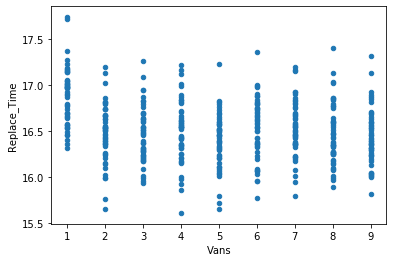

In [21]:
#grouped = replace[replace['Vans'] < 10].groupby("Vans")
#grouped['Replace_Time'].plot.hist()
replace[replace['Vans'] < 10].plot(kind='scatter', x='Vans', y='Replace_Time')